In [23]:
using Omega
using Flux, DiffEqFlux, DifferentialEquations, Plots, DiffEqNoiseProcess

In this experiment we use the Lotka-Volterra model for counterfactual reasoning about population dynamics.
The Lotka-Volterra model is a pair of differential equations which represent interacting populations of predators (e.g. wolves) and prey (e.g. rabbits):

\begin{equation}
{\frac {dx}{dt}} =\alpha x-\beta xy \;\;\;\;\;\;
{\frac {dy}{dt}} =\delta xy-\gamma y
\end{equation}

where $x(t)$ and $y(t)$ represents the prey and predator  respectively.
Parameters $\alpha, \beta, \delta$ and $\gamma$ are positive constants which represent growth rates.

Suppose that after observing for 10$ days until `t_now = 20`, we discover that  the rabbit population is unsustainably high.
We want to ask counterfactual questions: how would an intervention now affect the future; had we intervened in this past, could we have avoided this situation?

### The prior: differential equations model for population dynamics

lotka_volterra represents dynamics of wolves and rabbit populations over time

In [24]:
function lotka_volterra(du, u, p, t)
  x, y = u    # x, y = u[1], u]2] = prey. predator
  α, β, δ, γ = p
  du[1] = dx = α*x - β*x*y
  du[2] = dy = -δ*y + γ*x*y
end

lotka_volterra (generic function with 1 method)

Initial conditions of dynamical system are uniformly distributed

In [25]:
u0 = uniform(0.5, 1.5, (2,))

11268:Uniform([0.5, 0.5], [1.5, 1.5])::Array{Float64,1}

At `t_now` we observe the populations

In [26]:
t_now = 20.0

20.0

The time span of the ODE integration is from 0 to `t_now`.  We make it a constant random variable to be easily intervenable

In [27]:
tspan = constant((0.0, t_now))

11269:getfield(Omega, Symbol("##1#2")){Tuple{Float64,Float64}}((0.0, 20.0))()::Tuple{Float64,Float64}

Prior over Lotka-Volterra parameters

In [28]:
p = ciid(ω -> [uniform(ω, 1.3, 1.7), uniform(ω, 0.7, 1.3), uniform(ω, 2.7, 3.3), uniform(ω, 0.7, 1.3)])

11270:getfield(Main, Symbol("##46#47"))()()::Array{Float64,1}

A distribution over simulation problems and solutions

In [29]:
prob = ciid(ω -> ODEProblem(lotka_volterra, u0(ω), tspan(ω), p(ω)))
sol = lift(solve)(prob)

11272:Omega.reifyapply(DiffEqBase.solve, getfield(Main, Symbol("##48#49"))())::Any

Plot four samples of time series from the prior

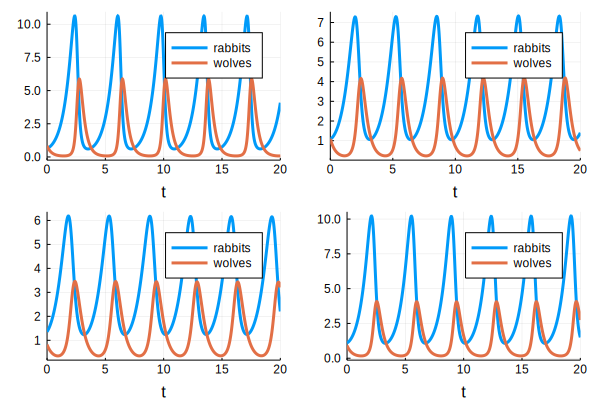

In [30]:
plotts(sol...; kwargs...) = plot(sol..., label = ["rabbits" "wolves"]; kwargs...)
plot(plotts(rand(sol)), plotts(rand(sol)), plotts(rand(sol)), plotts(rand(sol)), layout = (2, 2))

### Counter-factual model (a random random variable over `solve(ODEProblem...))`

In [31]:
"Generate a counterfatual model"
function gencf(; affect! = integrator -> integrator.u[2] /= 2.0,
                 t_int = uniform(tspan[1], tspan[2]/2.0),
                 tspan = tspan)
  condition = ciid(ω -> (u, t, integrator) -> t == t_int(ω))
  cb = DiscreteCallback(condition, affect!)
  # Solution to differential equation with intervention
  sol_int = ciid(ω -> solve(ODEProblem(lotka_volterra, u0(ω), tspan(ω), p(ω)),
                            EM(),
                            callback = DiscreteCallback(condition(ω), affect!),
                            tstops = t_int(ω)))
end

gencf

### Effect of (observed too many rabbits)

In [32]:
"Total number of rabbits"
function totalrabbits_(ω; ndays = 10)
  sol_ = sol(ω)
  n = length(sol_)
  rabbits = [sol_[i][1] for i = (n - ndays):n]
  sum(rabbits)
end

totalrabbits_

`totalrabbits` is a random variable whose values depends on the prior of the ODE

In [33]:
totalrabbits = ciid(totalrabbits_)

11277:totalrabbits_()::Any

There are too many rabbits if sum is 5 for previous ndays = 10

In [34]:
toomanyrabbits = totalrabbits ==ₛ 5.0

11278:Omega.reifyapply(Omega.Soft.softeq, totalrabbits_, 5.0)::Any

Next, we examine the effect of action.  According to Pearl, action means intervening on the random variable being observed, which does not affect the past
In particular, if we were to increase the predator population by 5 at t_now, would the rabbit population be reduced?

Now we construct an intervened model where the we add 1.0 to the number of rabbits (prey)

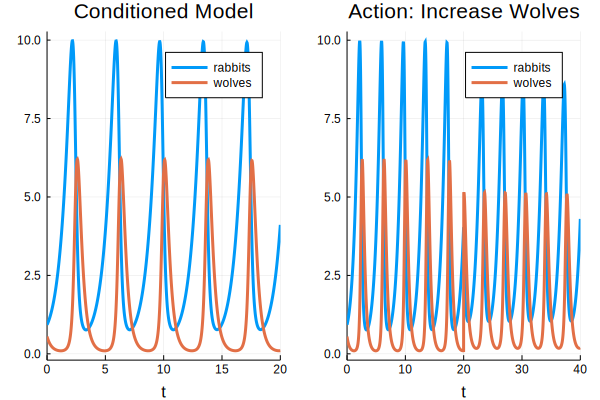

In [35]:
sol_inc_wolves = gencf(; affect! = integrator -> integrator.u[2] += 5.0,
                      t_int = constant(t_now),
                      tspan = constant((0, t_now * 2)))

function plot_effect_action(; n = 100, alg = SSMH, kwargs...)
  samples = rand((toomanyrabbits, sol, sol_inc_wolves), toomanyrabbits, n; alg = alg, kwargs...)
  norabbit_, sol_, sol_inc_wolves_ = ntranspose(samples)
  p1 = plotts(sol_[end], title = "Conditioned Model")
  p2 = plotts(sol_inc_wolves_[end], title = "Action: Increase Wolves")
  p1, p2
end
p1, p2 = plot_effect_action(); plot(p1, p2, layout = (1, 2))

We can see the treatment effect of action.  I.e. rather than look a particular values, look at the the distribution over change.

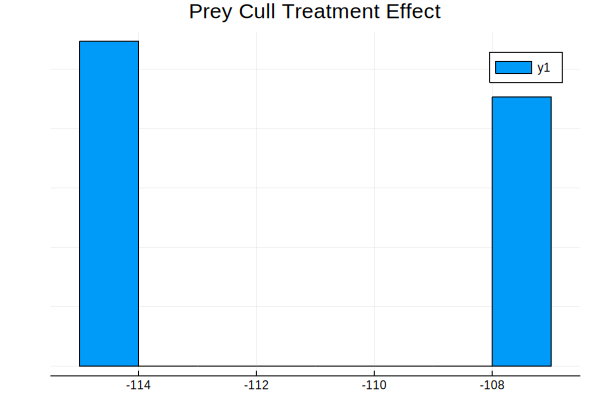

In [36]:
"Extract values from ODE solution: population `id` between times `a` and `b`"
function extractvals(v, id, a, b, ::Type{T} = Float64) where T
  res = Float64[]
  for i = 1:length(v)
    if a < v.t[i] < b
      push!(res, v.u[i][id])
    end
  end
  res
end

"Effect of increasing the number of predators"
function plot_treatment_action(; n = 10000, alg = SSMH, kwargs...)
  samples = rand((toomanyrabbits, replace(sol, tspan => constant((0, t_now * 2))), sol_inc_wolves), toomanyrabbits, n; alg = alg, kwargs...)
  norabbit_, sol_, sol_inc_wolves_ = ntranspose(samples)
  a = [sum(extractvals(a, 1, 20.0, 40.0)) for a in sol_[div(n, 2):n]]
  b = [sum(extractvals(a, 1, 20.0, 40.0)) for a in sol_inc_wolves_[div(n, 2):n]]
  # @show unique(b .- a)
  # @show b .- a
  histogram(b .- a, title = "Prey Cull Treatment Effect", yaxis = false)
end
plot_treatment_action()

### Counter Factual
Next, we consider the counterfactual: had we made an intervention at some previous time `t < t_now`, would the rabbit population have been less than it actually was over the last 10 days?
First we choose a random intervention time: `t_int`

In [37]:
t_int = uniform(tspan[1], tspan[2]/2.0)

21398:Uniform(Omega.reifyapply, Omega.reifyapply)::Float64

Construct the model that increases the number of predators at some time in the past

intervention occured at time 9.088404376570496
temps = [2.06115e-9, 4.53999e-5, 1.0, 22026.5]


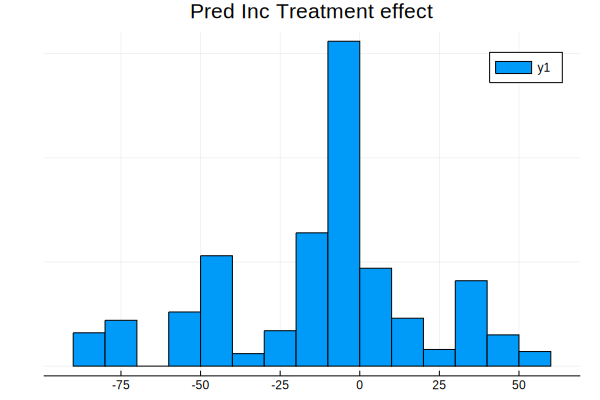

In [38]:
sol_inc_pred_past = gencf(; t_int = t_int,
                            affect! = integrator -> integrator.u[2] += 2.0)
# Construct the model that decreases the number of prey at some time in the past
sol_cull_prey_past = gencf(; t_int = t_int,
                             affect! = integrator -> integrator.u[1] += 2.0)

function plot_inc_pred(; n = 100, alg = SSMH, kwargs...)
  samples = rand((t_int, toomanyrabbits, sol, sol_inc_pred_past, sol_cull_prey_past), toomanyrabbits, n; alg = alg, kwargs...)
  t_int_, nor, sol_, sol_inc_pred_past_, sol_cull_prey_past_  = ntranspose(samples)
  println("intervention occured at time $(t_int_[end])")
  x1, y1 = ntranspose(sol_[end].u)
  x2, y2 = ntranspose(sol_inc_pred_past_[end].u)
  m = max(maximum(x1), maximum(y1), maximum(x2), maximum(y2))

  p1 = plotts(sol_[end], title = "Conditioned Model", ylim = [0, m])
  p2 = plotts(sol_inc_pred_past_[end], title = "Counterfactual: Inc Predators", ylim = [0, m])
  p3 = plotts(sol_cull_prey_past_[end], title = "Counterfactual: Cull Prey", ylim = [0, m])
  p1, p2, p3
end
p1, p2, p3 = plot_inc_pred(); plot(p1, p2, p3, layout = (1, 3))
# Choosing a fixed time to intervene (e.g. $t = 5$)  is likely undesirable because it corresponds to an arbitrary (i.e.: parameter dependent) point in the predator-prey cycle.
# Instead, the following snippet selects the intervention dynamically as a function of values in the non-intervened world.
# `maxindex` is an auxilliary function which selects the index of the largest value and hence \texttt{tmostwolves} is a random variable over such values.
  "Total number of rabbits"
function totalrabbits_(ω; ndays = 10)
  sol_ = sol(ω)
  n = length(sol_)
  rabbits = [sol_[i][1] for i = (n - ndays):n]
  sum(rabbits)
end


"Affect of increasing the number of predators"
function plot_treatment(; n = 1000, alg = Replica, kwargs...)
  samples = rand((t_int, toomanyrabbits, sol, sol_inc_pred_past), toomanyrabbits, n; alg = alg, kwargs...)
  t_int_, nor, sol_, sol_inc_pred_past_ = ntranspose(samples)
  sol_[end], sol_inc_pred_past_[end]
  a = [sum(extractvals(a, 1, 0.0, 10.0)) for a in sol_[500:1000]]
  b = [sum(extractvals(a, 1, 0.0, 10.0)) for a in sol_inc_pred_past_[500:1000]]
  histogram(b .- a, title = "Pred Inc Treatment effect", yaxis = false)
end
plot_treatment()

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*